# AIOps anomaly detection

Anomaly detection detects data points in data that does not fit well with the rest of data. In this notebook we demonstrate how to do anomaly detection using Zouwu's built-in model MTNet

For demonstration, we use the publicly available cluster trace data cluster-trace-v2018 of Alibaba Open Cluster Trace Program. You can find the dataset introduction <a href="https://github.com/alibaba/clusterdata/blob/master/cluster-trace-v2018/trace_2018.md" target="_blank">here</a>. In particular, we use machine usage data to demonstrate anomaly detection, you can download the separate data file directly with <a href="http://clusterdata2018pubcn.oss-cn-beijing.aliyuncs.com/machine_usage.tar.gz" target="_blank">machine_usage</a>.

## Helper functions

This section defines some helper functions to be used in the following procedures. You can refer to it later when they're used.

In [1]:
def get_drop_ts_and_len(df, target_col="cpu_usage", allow_missing_num=3):
    """
    get start index which with consecutive missing num larger than allow_missing_num
    """
    missing_num = df[target_col].isnull().astype(int).groupby(df[target_col].notnull().astype(int).cumsum()).sum()
    missing_num = missing_num[missing_num > 0]
    drop_ts = df.iloc[(missing_num.index + missing_num.cumsum() - missing_num).values].index
    drop_ts = drop_ts[missing_num > allow_missing_num]
    drop_missing_num = missing_num[missing_num > allow_missing_num]
    drop_len = drop_missing_num.values
    return drop_ts, drop_len

In [2]:
def rm_missing_day(start_dts, missing_lens, df):
    """
    Drop day that contains more than 3 consecutive missing values.
    If consecutive missing values across day, we remove the data for an extra hour.
    """ 
    for start_time, l in zip(start_dts, missing_lens):
        start = start_time.replace(hour=0, minute=0, second=0)
        start_day_end = start + pd.Timedelta(hours=24)
        start_day_end = start_day_end - pd.Timedelta(minutes=1)
        end_time = start_time + l*pd.Timedelta(minutes=1)
        if start_day_end < end_time:
            end = end_time + pd.Timedelta(hours=1)
        else:
            end = start_day_end
        df = df.drop(df[start:end].index)
    return df

In [3]:
def train_val_test_split(df, val_ratio, test_ratio, look_back, horizon):
    """
    Split the dataset into train、validation and test part.
    """ 
    total_num = df.index.size
    test_num = int(total_num * test_ratio)
    val_num = int(total_num * val_ratio)
    
    test_split_index = test_num + look_back + horizon - 1
    val_split_index = test_split_index + val_num 
    
    train_df = df.iloc[:-(test_num + val_num)]  
    val_df = df.iloc[-val_split_index: -test_num]
    test_df = df.iloc[-test_split_index: ]
    
    return train_df, val_df, test_df

In [4]:
def roll_data(dataset, look_back, target_col_index):
    """
    Generate input samples from rolling
    """
    X, Y = [], []
    for i in range(len(dataset) - look_back):
        X.append(dataset[i: (i + look_back)])
        Y.append(dataset[i + look_back, [target_col_index]])
    return np.array(X), np.array(Y)

In [5]:
def unscale(scaler, y, target_col_indexes):
    """
    data needs to be normalized (scaled) before feeding into models. 
    This is to inverse the effect of normlization to get reasonable forecast results.
    """
    dummy_feature_shape = scaler.scale_.shape[0]
    y_dummy = np.zeros((y.shape[0], dummy_feature_shape))
    y_dummy[:, target_col_indexes] = y
    y_unscale = scaler.inverse_transform(y_dummy)[:,target_col_indexes]
    return y_unscale

In [6]:
EPSILON = 1e-10
def sMAPE(y_true, y_pred):
    """
    Symmetric Mean Average Percentage Error
    """
    output_errors = np.mean(100 * np.abs(y_true - y_pred)/(np.abs(y_true) + np.abs(y_pred) + EPSILON), axis=0,)
    return np.mean(output_errors)


In [7]:
def get_result_df(df, y_pred_unscale, ano_index, look_back):
    """
    Add prediction and anomaly value to dataframe.
    """
    result_df = pd.DataFrame({"y_true":df[look_back:]["cpu_usage"], "y_pred": y_pred_unscale.squeeze()})
    result_df['anomalies'] = 0
    for i in ano_index:
        result_df.anomalies[i] = 1
    result_df['anomalies'] = result_df['anomalies'] > 0
    return result_df 

In [8]:
def plot_anomalies_value(date, y_true, y_pred, anomalies):
    """
    plot the anomalies value
    """
    fig, axs = plt.subplots(figsize=(16,6))
    
    axs.plot(date, y_true,color='blue', label='y_true')
    axs.plot(date, y_pred,color='orange', label='y_pred')
    axs.scatter(date[anomalies].tolist(), y_true[anomalies], color='red', label='anomalies value')
    axs.set_title('the anomalies value')
    
    plt.xlabel('datetime')
    plt.legend(loc='upper left')
    plt.show()

## Download raw dataset and load into dataframe

Now we download the dataset and load it into a pandas dataframe.Steps are as below:
* First, download the raw data <a href="http://clusterdata2018pubcn.oss-cn-beijing.aliyuncs.com/machine_usage.tar.gz" target="_blank">machine_usage</a>. Or run the script `get_data.sh` to download the raw data..It will download the resource usage of each machine from m_1932 to m_2085. 
* Second, run `grep m_1932 machine_usage.csv > m_1932.csv` to extract records of machine 1932. Or run `extract_data.sh`.We use machine 1932 as an example in this notebook.You can choose any machines in the similar way.
* Finally, use pandas to load `m_1932.csv` into a dataframe as shown below.

In [9]:
import os 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [10]:
df_1932 = pd.read_csv("m_1932.csv", header=None, usecols=[1,2,3], names=["time_step", "cpu_usage","mem_usage"])

Below are some example records of the data and the line chart of the raw data.

In [11]:
df_1932.head()

,time_step,cpu_usage,mem_usage
0,386640,41,92
1,386670,43,92
2,386690,44,92
3,386800,46,92
4,386930,44,93


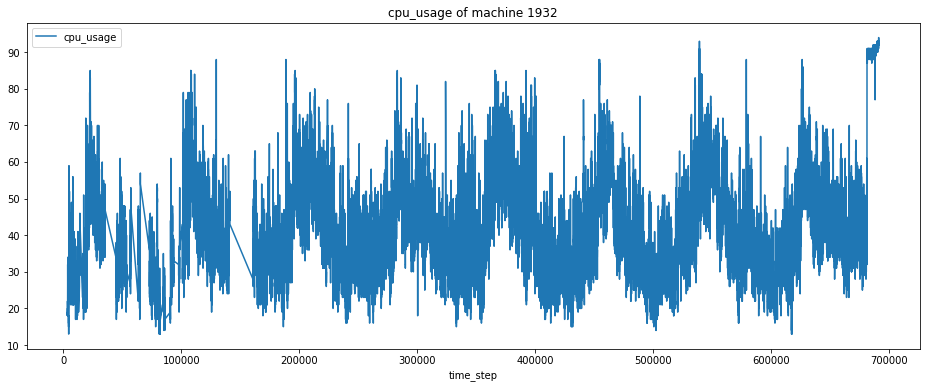

In [12]:
df_1932.sort_values(by="time_step").plot(y="cpu_usage", x="time_step", figsize=(16,6),title="cpu_usage of machine 1932")

## Data pre-processing

Now we need to do data cleaning and preprocessing on the raw data. Note that this part could vary for different dataset. 

For the machine_usage data, we are using the processing contains 2 parts:
1. Change the time unit, and then count the average of `cpu_usage` in the same time
2. Check missing values and handle missing data(fill or drop).

Chaneg the time unit to minute.

In [13]:
df_1932["ts_min"] = df_1932["time_step"]//60

Count the average of cpu_usage in the same time and draw the line chart.

In [14]:
resampled_df = df_1932.groupby("ts_min").agg({"cpu_usage":"mean"})

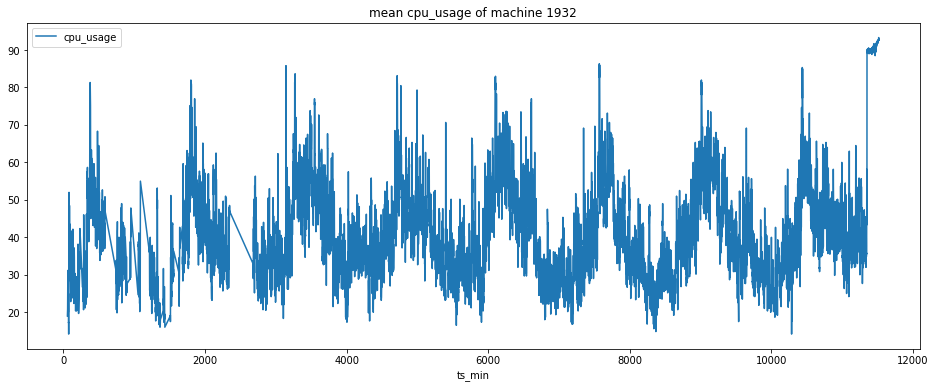

In [15]:
resampled_df.plot(figsize=(16,6),title="mean cpu_usage of machine 1932")

We need datetime information to generate related features,so re-adjust time series.

In [16]:
resampled_df.index = pd.to_datetime(resampled_df.index, unit='m', origin=pd.Timestamp('2018-01-01'))
full_idx = pd.date_range(start=resampled_df.index.min(), end=resampled_df.index.max(),freq='T')
resampled_df = resampled_df.reindex(full_idx)

In [17]:
resampled_df.head()

,cpu_usage
2018-01-01 00:56:00,19.000000
2018-01-01 00:57:00,19.666667
2018-01-01 00:58:00,19.666667
2018-01-01 00:59:00,20.833333
2018-01-01 01:00:00,25.666667


Here, we drop day with more than 3 consecutive missing values and fill other missing values remained.

In [18]:
drop_ts,drop_len = get_drop_ts_and_len(resampled_df)
df = rm_missing_day(drop_ts, drop_len,resampled_df)

In [19]:
df.head()

,cpu_usage
2018-01-03 00:00:00,29.666667
2018-01-03 00:01:00,33.000000
2018-01-03 00:02:00,37.833333
2018-01-03 00:03:00,34.666667
2018-01-03 00:04:00,37.166667


In [20]:
print("no. of n/a values:")
print(df.isna().sum())

no. of n/a values:
cpu_usage    21
dtype: int64


We use ffill method to fill the empty data.

In [21]:
df.ffill(inplace=True)

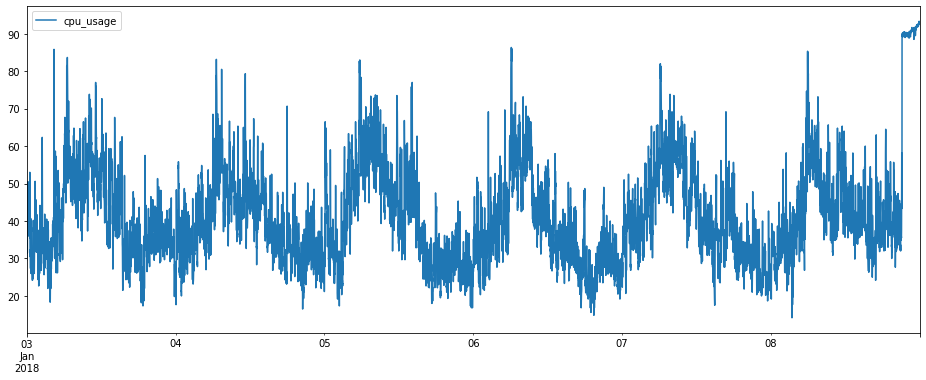

In [22]:
df.plot(figsize=(16,6))

## Feature Engineering

For feature engineering, we use hour as features.

In [23]:
df["hour"] = df.index.hour

In [24]:
df.head()

,cpu_usage,hour
2018-01-03 00:00:00,29.666667,0
2018-01-03 00:01:00,33.000000,0
2018-01-03 00:02:00,37.833333,0
2018-01-03 00:03:00,34.666667,0
2018-01-03 00:04:00,37.166667,0


## Data preparation

Now we split the dataset into train, validation and test.

In [25]:
val_ratio = 0.1
test_ratio = 0.1
# we look back one hour data which is of the frequency of 1min.
look_back = 60
horizon = 1

train_df, val_df, test_df = train_val_test_split(df, val_ratio, test_ratio, look_back, horizon)

In [27]:
print("size of data after division")
train_df.index.size, val_df.index.size, test_df.index.size

size of data after division


(6912, 924, 924)

Then standardize train, test data and featues

In [28]:
from sklearn.preprocessing import StandardScaler
standard_scaler = StandardScaler()
scaled_train = standard_scaler.fit_transform(train_df)
scaled_val = standard_scaler.transform(val_df)
scaled_test = standard_scaler.transform(test_df)

Last, we generate model input samples by sliding window along time axis. Since univariant and multivariant forcasting uses different input data shape, we prepare data for each type of forcasting respectively.

In [33]:
import numpy as np
x_train, y_train = roll_data(scaled_train, look_back, target_col_index=0)
x_val, y_val = roll_data(scaled_val, look_back, target_col_index=0)
x_test, y_test = roll_data(scaled_test, look_back, target_col_index=0)
x_test.shape,y_test.shape

((864, 60, 2), (864, 1))

## Time series forecasting

In [34]:
from zoo.zouwu.model.forecast import MTNetForecaster

First, we initialize a mtnet_forecaster according to input data shape. Specifcally, look_back should equal (lb_long_steps+1)*lb_long_stepsize .Details refer to zouwu docs.

In [35]:
mtnet_forecaster = MTNetForecaster(target_dim=horizon,
                                   feature_dim=x_train.shape[-1],
                                   lb_long_steps=3,
                                   lb_long_stepsize=15
    )

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
If using Keras pass *_constraint arguments to layers.


MTNet needs to preprocess the X into another format, so we call MTNetForecaster.preprocess_input on train_x and test_x.

In [36]:
# mtnet requires reshape of input x before feeding into model.
x_train_mtnet = mtnet_forecaster.preprocess_input(x_train)
x_val_mtnet = mtnet_forecaster.preprocess_input(x_val)
x_test_mtnet = mtnet_forecaster.preprocess_input(x_test)

Now we train the model and wait till it finished.

In [37]:
%%time
hist = mtnet_forecaster.fit(x = x_train_mtnet, y = y_train, batch_size=128, epochs=20)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 6852 samples
Epoch 1/20
6852/6852 [==============================] - 21s 3ms/sample - loss: 0.8058 - mean_squared_error: 1.0500
Epoch 2/20
6852/6852 [==============================] - 14s 2ms/sample - loss: 0.5794 - mean_squared_error: 0.6077
Epoch 3/20
6852/6852 [==============================] - 14s 2ms/sample - loss: 0.4439 - mean_squared_error: 0.3579
Epoch 4/20
6852/6852 [==============================] - 14s 2ms/sample - loss: 0.3915 - mean_squared_error: 0.2823
Epoch 5/20
6852/6852 [==============================] - 15s 2ms/sample - loss: 0.3618 - mean_squared_error: 0.2419
Epoch 6/20
6852/6852 [==============================] - 15s 2ms/sample - loss: 0.3467 - mean_squared_error: 0.2218
Epoch 7/20
6852/6852 [==============================] - 15s 2ms/sample - loss: 0.3395 - mean_squared_error: 0.2116
Epoch 8/20
6852/6852 [==============================] - 15s 2ms/sample - loss: 

Use the model for prediction and inverse the scaling of the prediction results

In [38]:
y_pred_val = mtnet_forecaster.predict(x_val_mtnet)
y_pred_test = mtnet_forecaster.predict(x_test_mtnet)

Since we have used standard scaler to scale the input data (including the target values), we need to inverse the scaling on the predicted values too. 

In [39]:
y_pred_val_unscale = unscale(standard_scaler, y_pred_val, [0])
y_pred_test_unscale = unscale(standard_scaler, y_pred_test, [0])
y_val_unscale = unscale(standard_scaler,y_val,[0])
y_test_unscale = unscale(standard_scaler,y_test,[0])

Calculate the symetric mean absolute percentage error.

In [41]:
# evaluate with sMAPE
print("sMAPE is",sMAPE(y_pred_test_unscale, y_test_unscale))

sMAPE is 6.479411334554062


## Anomaly detection

Use anomaly detector interface in zoo.zouwu.model.anomaly

In [42]:
from zoo.zouwu.model.anomaly import ThresholdDetector, ThresholdEstimator

ratio=0.01
threshold = ThresholdEstimator().fit(y=y_val_unscale,yhat=y_pred_val_unscale,ratio=ratio)
print("The threshold of validation dataset is:",threshold)

The threshold of validation dataset is: 13.98788363569501


We use the threshold to calculate the index of anomalies in test and val dataset.

In [44]:
val_res_ano_idx = ThresholdDetector().detect(y=y_val_unscale,yhat=y_pred_val_unscale,threshold=threshold)
test_res_ano_idx = ThresholdDetector().detect(y=y_test_unscale,yhat=y_pred_test_unscale,threshold=threshold)
print("The index of anomalies in validation dataset is:",val_res_ano_idx)
print("The index of anomalies in test dataset is:",test_res_ano_idx)

The index of anomalies in validation dataset is: [112, 265, 406, 436, 502, 625, 632, 641, 842]
The index of anomalies in test dataset is: [68, 79, 336, 387, 397, 443, 532, 693, 694, 695, 696, 697, 698, 699, 700, 701, 702, 703, 704, 705, 706, 707, 708, 709, 710, 711, 712, 713, 714, 715, 716, 717, 718, 719, 720, 721, 722, 723, 724, 725, 726, 727, 728, 729, 730, 731, 732, 733, 734, 735, 736, 737, 738, 739, 740, 741, 742, 743, 744, 745, 746, 747, 748, 749, 750, 751, 752, 753, 754, 755, 756, 757, 758, 759, 760, 761, 762, 763, 764, 765, 766, 767, 768, 769, 770, 771, 772, 773, 774, 775, 776, 777, 778, 779, 780, 781, 782, 783, 784, 785, 786, 787, 788, 789, 790, 791, 792, 793, 794, 795, 796, 797, 798, 799, 800, 801, 802, 803, 804, 805, 806, 807, 808, 809, 810, 811, 812, 813, 814, 815, 816, 817, 818, 819, 820, 821, 822, 823, 824, 825, 826, 827, 828, 829, 830, 831, 832, 833, 834, 835, 836, 837, 838, 839, 840, 841, 842, 843, 844, 845, 846, 847, 848, 849, 850, 851, 852, 853, 854, 855, 856, 857, 858

Get a new dataframe which contains `y_true`，`y_pred`，`anomalies` value.

In [45]:
val_result_df = get_result_df(val_df, y_pred_val_unscale, val_res_ano_idx, look_back)
test_result_df = get_result_df(test_df, y_pred_test_unscale, test_res_ano_idx, look_back)

Draw anomalies in line chart.

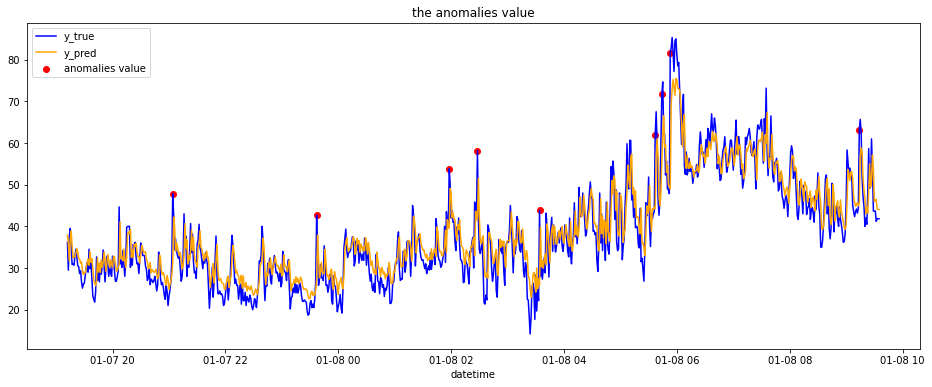

In [46]:
plot_anomalies_value(val_result_df.index, val_result_df.y_true, val_result_df.y_pred, val_result_df.anomalies)

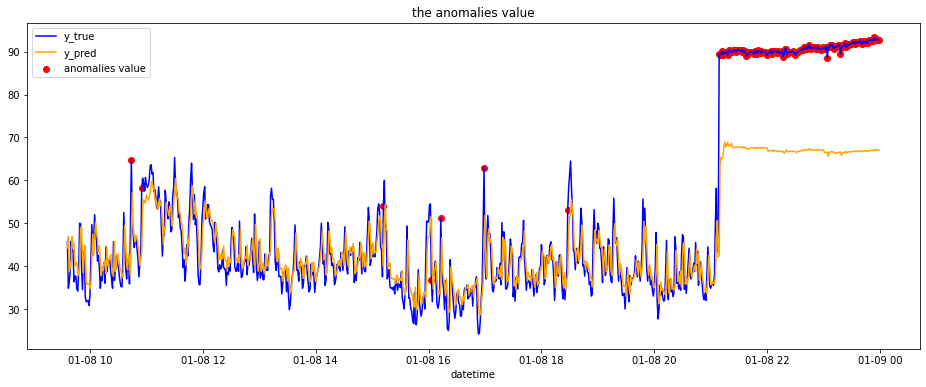

In [47]:
plot_anomalies_value(test_result_df.index, test_result_df.y_true, test_result_df.y_pred, test_result_df.anomalies)